# Speech Recognition B 
---------------------------------------------

In [2]:
from IPython.core.display import HTML
import numpy as np
import matplotlib
import scipy
from scipy.stats import norm
from scipy.stats import binom
import pandas as pd
params = {'figure.figsize':(12,6), # These are plot parameters
         'xtick.labelsize': 16,
         'ytick.labelsize':16,
         'axes.titlesize':18,
         'axes.labelsize':18,
         'lines.markersize':4,
         'legend.fontsize': 20}
matplotlib.rcParams.update(params)
from matplotlib import pyplot as plt
import random
from ipywidgets import *
import numpy.linalg
from IPython.display import display
from IPython.core.display import HTML
from notebook.nbextensions import enable_nbextension 
%matplotlib inline

print('The libraries loaded successfully')

The libraries loaded successfully


This chapter is a short introduction to techniques used in machine learning: stochastic gradient, expectation maximization, matching pursuit.


## Stochastic Gradient Descent

Consider the minimization of $g(\theta) = E[f(\theta, X)]$ when one is given i.i.d. samples $X_n$ of $X$.  Here, $\theta$ are the parameters of some policy and $f(\theta, X)$ is the cost of using the policy with parameters $\theta$ when the realization of the random variables happens to be $X$.

For instance, $\theta$ defines a scheduling policy in a hospital and $X$ is the realization of the procedure durations, $f(\theta, X)$ is then a cost that reflects the waiting time of patients, the down time of surgeons, the idle time of operating rooms, and the overtime of the staff.

The key idea is to use an approximation of the following gradient projection algorithm:

$$\theta_{n+1} = [\theta_n - \alpha \nabla g(\theta_n)]_{\cal C}.$$

In this expression, $\alpha$ controls the step size of the updates and $\nabla g$ is th gradient of $g$ with respect to $\theta$.  Also, $[\cdot]_{\cal C}$ indicate the projection on the set ${\cal C}$ of feasible values of $\theta$.  Thus, $\theta$ is updated in the direction of steepest descent of $g$.

Since $g(\theta) = E[f(\theta, X)]$ and one has access only to samples $X_n$ of $X$, one does not know the function $g(\theta)$ explictly.  So, how can one evaluate the gradient?

One key idea is that, under mild conditions,

$$\nabla g(\theta) = E[ \nabla f(\theta, X) ] $$

where $\nabla f(\theta, X)$ is the gradient of $f$ with respect to $\theta$.  Essentially, the gradient is a difference and expectation is linear.  

Also, by the law of large numbers, one has

$$ E[ \nabla f(\theta, X) ] \approx \frac{1}{N} [ \nabla f(\theta, X_1) + \cdots + \nabla f(\theta, X_N)]. $$

This suggests that the following algorithm should be a good approximation to the gradient projection algorithm:

$$ \theta_{n+1} = [\theta_n - \alpha \nabla f(\theta_n, X_n)]_{\cal C}.$$

Indeed, if the step size $\alpha$ is small enough, the updates of $\theta$ tend to follow the gradient direction.  The algorithm above is called the **Stochastic Gradient Descent (SGD)** algorithm.

### Example 1: Find the median

In this example, the goal is to minimize $g(\theta) = E[|X - \theta|]$.  The minimizing $\theta$ is the **median** of the distribution of $X$, i.e., a value $\theta$ such that $P(X < \theta) = 1/2$.  The SGD
algorithm is

$$\theta_{n+1} = \theta_n + \alpha_n [ 1\{X_n > \theta_n\} - 1\{X_n < \theta_n\} ].$$

Thus, $\theta_n$ increases when one sees a sample larger than $\theta_n$ and it decreases otherwise.  When $\theta_n$ is smaller than the median, it increases with a probability larger than $1/2$ and decreases otherwise.  Thus, one expects $\theta_n$ to converge to the median.

For a concrete example, say that $X = U[0, 1]$.  We use this simple example to illustrate the key argument for the convergence of SGD.
Note that $P(X_n < \theta_n) = \theta_n$, so that $\theta_{n+1} = \theta_n - \alpha_n$ with probability $\theta_n$ and $\theta_{n+1} = \theta_n + \alpha_n$ with probability $1 -\theta_n$.  Thus, $\theta_{n+1} = \theta_n + \alpha_n (1 - 2 \theta_n) + v_n$ where $v_n$ is a random variable that always takes values in $[- 2 \alpha_n, 2 \alpha_n]$ and is zero mean given $\theta_0, \ldots, \theta_n$.  If we ignore the noise $v_n$, we have $\theta_{n+1} = \theta_n + \alpha_n (1 - 2 \theta_n)$.
A simple argument shows that if $\alpha_n \to 0$ and $\sum_n \alpha_n = \infty$, then $\theta_n \to 0.5$.
The main idea is then to show that the noise does not change this convergence if $\sum_n \alpha_n^2 < \infty$.
The technical step is to observe that $w_n := \sum_{m=1}^n \alpha_m v_m$ is a martingale with the property that
$E(w_n^2) \leq K < \infty$ for all $n$.  Thus, $w_m$ is a 'square integrable martingale' so that it converges to a finite random variables.  This implies that $\sum_{m=n}^\infty \alpha_m v_m \to 0$ as $n \to \infty$.  Hence, the noise has a negligible 'tail' and does not modify the convergence of $\theta_n$. 
  

Let's try the algorithm in the following cases with $\alpha_n = a/(n+40)$:

* Case (a): $U[0,1]$

* Case (b): $U\{1, 2, \ldots, 6\}$

* Case (c): $0.5 {\cal N}(0, 1) + 0.5 {\cal N}(2,1)$.

You will note that the speed of convergence depends on $a$.  Also, the median of $U\{1, 2, \ldots, 6\}$
is any number in $(3, 4)$.

In [3]:
def dummy(Nd,ad,cased):
    global N, a, case
    N, a, case = int(Nd), float(ad), str(cased)

ad = widgets.Dropdown(options=['0.2', '0.4', '0.6', '0.8','1','1.2','1.4','1.6','1.8','2'],value='1',description='$a$',disabled=False)
Nd = widgets.Dropdown(options=['10', '30', '50', '70','100','150','200','250','300','350','400','450','500'],value='300',description='N',disabled=False)
cased = widgets.ToggleButtons(options=['(a)', '(b)','(c)'],description='Case:',disabled=False,button_style='info',tooltip='Description')

z = widgets.interactive(dummy, Nd = Nd, ad = ad, cased=cased) 
display(z)

interactive(children=(Dropdown(description='N', index=8, options=('10', '30', '50', '70', '100', '150', '200',…

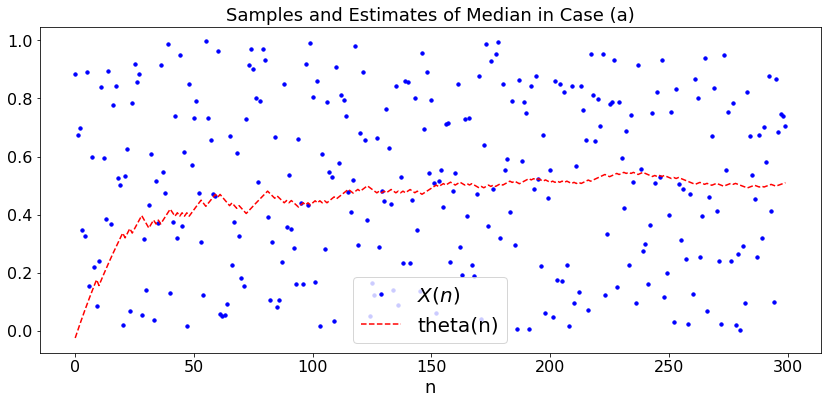

In [4]:
P = np.matrix('0 0.5 0 0.5 0; 0 0 1.0 0 0; 1.0 0 0 0 0;  0.33 0.33 0 0 0.34; 0 0.5 0.5 0 0')

def SGD1(case,a,N):  # SGD with case w, step size a
    t = np.arange(0,N)
    x = np.arange(0.0,N)
    theta = np.arange(0.0,N)
    theta[0] = 0
    
    for n in range(N):  
        if case == '(a)':
            x[n] = np.random.random()
        elif case == '(b)':
            x[n] = np.random.randint(1,7)
        else:
            if np.random.random() < 0.5:
                x[n] = np.random.normal(0,1)
            else:
                x[n] = np.random.normal(2,1)
        theta[n] = theta[max(0,n-1)] - a*(1 - 2*(x[n-1] > theta[n-1]))/(n+40) 
        
    plt.figure(figsize = (14,6))
    plX, = plt.plot(t,x,'bo', markersize = 1000/N,label='$X(n)$')
    plt.legend()
    pltheta, = plt.plot(t,theta,'r--',label='theta(n)')
    plt.legend()
    plt.title('Samples and Estimates of Median in Case ' + case)
    plt.xlabel('n')
        
SGD1(case,a,N)

### Example 2: Quadratic Least Squares

In this example, we use SGD to find the values of $(a, b, d)$ that minimize $E((Y - a - bX - cX^2)^2)$ by using samples $(X_n, Y_n)$ of $(X, Y)$.  We replace the gradient $\nabla E((Y - a - bX - cX^2)^2) = E(\nabla(Y - a - bX - cX^2)^2)$ by the realization of $\nabla(Y - a - bX - cX^2)^2 = 2 (Y - a - bX - cX^2) \nabla \nabla(Y - a - bX - cX^2)$.  For instance, we replace 

$$\frac{\partial}{\partial b}  E((Y - a - bX - cX^2)^2) \mbox{ by } 2 (Y - a - bX - cX^2)( - X).$$

Accordingly, the SGD algorithm is as follows:

\begin{eqnarray*}
a_{n+1} &=& a_n + \alpha_n [Y_n - a_n - b_nX_n - cX_n^2] \\
b_{n+1} &=& b_n + \alpha_n [Y_n - a_n - b_nX_n - cX_n^2]X_n \\
c_{n+1} &=& c_n + \alpha_n [Y_n - a_n - b_nX_n - cX_n^2]X_n^2.
\end{eqnarray*}

We do this for $Y_n = 0.2 - X_n + 2X_n^2 + 1.3Z_n$ in case (a) and $Y_n = 0.4 + X_n - 2 X_n^2 + 1.3Z_n$ in case (b) where $X_n$ and $Z_n$ are i.i.d. ${\cal N}(0, 1)$. (See section 7.3.)  First, we run the code of section 7.3 to find the optimal values of $(a, b, c)$.  Then, we run SGD and track the values of $(a_n, b_n, c_n)$ that the algorithm produces.  Here again we use $\alpha_n = a/(n+40)$.

In [5]:
def dummy(Nd,ad,cased):
    global N, a, case
    N, a, case = int(Nd), float(ad), str(cased)

ad = widgets.Dropdown(options=['0.2', '0.4', '0.6', '0.8','1','1.2','1.4','1.6','1.8','2'],value='1',description='$a$',disabled=False)
Nd = widgets.Dropdown(options=['10', '30', '50', '70','100','150','200','250','300','350','400','450','500'],value='300',description='N',disabled=False)
cased = widgets.ToggleButtons(options=['(a)', '(b)','(c)'],description='Case:',disabled=False,button_style='info',tooltip='Description')

z = widgets.interactive(dummy, Nd = Nd, ad = ad, cased=cased) 
display(z)

interactive(children=(Dropdown(description='N', index=8, options=('10', '30', '50', '70', '100', '150', '200',…

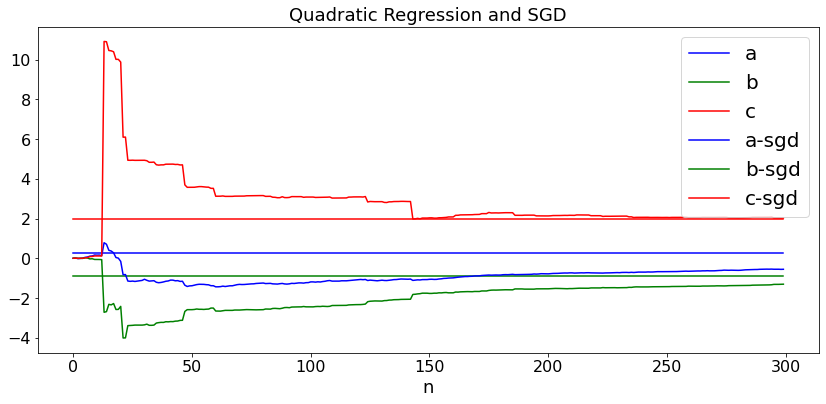

In [6]:
def SGD2(case,N,a):  # Simulation of QR and SGD QR 
    t = np.arange(0,N)
    x = np.arange(0.0,N)
    y = np.arange(0.0,N)
    aqr = np.arange(0.0,N)
    bqr = np.arange(0.0,N)
    cqr = np.arange(0.0,N)
    asgd = np.arange(0.0,N)
    bsgd = np.arange(0.0,N)
    csgd = np.arange(0.0,N)  
    for k in range(N):
        x[k]= np.random.normal()
        if case == '(a)':
            y[k] =  0.2 - x[k] +  2*x[k]**2 + 1.3*np.random.normal()
        else:
            y[k] =  0.4 + x[k] -  2*x[k]**2 + 1.3*np.random.normal()
    Sx = 0
    Sx2 = 0
    Sx3 = 0
    Sx4 = 0
    Sy = 0
    Sxy = 0
    Sx2y = 0
    for k in range(N):
        Sx = Sx + x[k]
        Sx2 = Sx2 + x[k]**2
        Sx3 = Sx3 + x[k]**3
        Sx4 = Sx4 + x[k]**4
        Sy = Sy + y[k]
        Sxy = Sxy + x[k]*y[k]
        Sx2y = Sx2y + x[k]**2*y[k]
    A = [[N,Sx,Sx2],[Sx,Sx2,Sx3],[Sx2,Sx3,Sx4]]
    Ainv = np.linalg.inv(A)
    V = [Sy, Sxy, Sx2y]
    W = np.dot(Ainv,V)
    AL = [[N, Sx],[Sx, Sx2]]
    ALinv = np.linalg.inv(AL)
    VL = [Sy, Sxy]
    WL = np.dot(ALinv,VL)
    for k in range(N):
        aqr[k] = W[0]
        bqr[k] = W[1]
        cqr[k] = W[2]
        
    asgd[0] = 0
    bsgd[0] = 0
    csgd[0] = 0
    
    for k in range(1,N):
        asgd[k] = asgd[k-1] + a*(y[k-1] - asgd[k-1] - bsgd[k-1]*x[k-1] - csgd[k-1]*x[k-1]**2)/(k + 40)  
        bsgd[k] = bsgd[k-1] + a*(y[k-1] - asgd[k-1] - bsgd[k-1]*x[k-1] - csgd[k-1]*x[k-1]**2)*x[k-1]/(k + 40)
        csgd[k] = csgd[k-1] + a*(y[k-1] - asgd[k-1] - bsgd[k-1]*x[k-1] - csgd[k-1]*x[k-1]**2)*x[k-1]**2/(k + 40)
    
    
    plt.figure(figsize = (14,6))
    plt.plot(t, aqr, c='b', label='a')
    plt.legend()
    plt.plot(t, bqr, c='g', label='b')
    plt.legend()
    plt.plot(t, cqr, c='r', label='c')
    plt.legend()
    plt.plot(t, asgd, c='b', label='a-sgd')
    plt.legend()
    plt.plot(t, bsgd, c='g', label='b-sgd')
    plt.legend()
    plt.plot(t, csgd, c='r', label='c-sgd')
    plt.legend()   
    plt.title('Quadratic Regression and SGD')
    plt.xlabel('n')
    
               
SGD2(case,N,a)
        

## Martingale Convergence

As we explained in Example 1 above, the key tool to prove the convergence of SGD is the **martingale convergence theorem**.  This result says that if $w_n$ is a martingale and $E(w_n^2) \leq K < \infty$, then 
$w_n \to w$ where $w$ is a finite random variable. Recall that $w_n$ is a martingale if $E[w_{n+1} | w_0, \ldots, w_n] = w_n$.  

### Example 1: 

Let $x_n$ be i.i.d. with mean $0$ and variance $\sigma^2$.  Let $w_0 = 0$ and $w_{n+1} = w_n + x_{n+1}/(n+1)$.  
Then $w_n$
is a martingale.  Moreover, 

$$E(w_n^2) = var(w_n) = var(x_ 1/1) + var(x_2/2) + \cdots + var(x_n/n) = \sigma^2(1 + 1/4 + \cdots + 1/n^2 )\leq \sigma^2\frac{\pi^2}{6}.$$

Consequently, by the martingale convergence theorem, $w_n \to w$ for some finite random variable $w$.

We simulate that process in two cases.

* Case (a): $x_n = {\cal N}(0, 1)$;

* Case (b): $x_n = U[-1, 1]$.

Note that the limit depends on the realization.

In [7]:
def dummy(Nd,cased):
    global N, case
    N, case = int(Nd), str(cased)

Nd = widgets.Dropdown(options=['100', '300', '500', '700','1000','1500','2000','2500','3000','3500','4000','4500','5000'],value='2000',description='N',disabled=False)
cased = widgets.ToggleButtons(options=['(a)', '(b)'],description='Case:',disabled=False,button_style='info',tooltip='Description')

z = widgets.interactive(dummy, Nd = Nd, cased=cased) 
display(z)

interactive(children=(Dropdown(description='N', index=6, options=('100', '300', '500', '700', '1000', '1500', …

In [8]:
def MG(case,N):  # LR 
    t = np.arange(0,N)
    w = np.arange(0.0,N)
    w[0] = 0
    
    for k in range(N-1):
        if case == '(a)':
            x =  np.random.normal()
        else:
            x =  - 1+ 2*np.random.random()
        w[k+1]=w[k] + x/(k+1)
    plt.figure(figsize = (14,6))
    plt.plot(t, w, c='b',label='$w_n$')
    plt.legend()
    plt.title('Martingale Convergence')
    plt.xlabel('n')
    plt.ylabel('w')
    plt.show()
            
case = widgets.ToggleButtons(options=['(a)', '(b)'],
    description='Case',
    disabled=False,
    button_style='info', 
    tooltip='Description',
#     icon='check'
) 



N = widgets.IntSlider(description='N', min = 100, max = 4000, step = 10, value = 2000)
        
z = widgets.interactive(MG, case = case, N = N) 
display(z)
        

interactive(children=(ToggleButtons(button_style='info', description='Case', options=('(a)', '(b)'), value='(a…

## Example 2

This example shows that adding a martingale noise does not modify the convergence.  Consider the following sequence that corresponds to the gradient algorithm to minimize $(y - 1)^2$;

$$y_{n+1} = y_n - \alpha_n 2 (y_n - 1).$$

We know that if we choose $\alpha_n = a/n$, then $y_n \to 1$.  We then consider

$$z_{n+1} = z_n - \alpha_n [2 (z_n - 1) + x_n]$$ 

where the $x_n$ are i.i.d. with mean zero and variance $\sigma^2$.  The simulaiton shows that $z_n \to 1$.  We simulate the two cases of Example 1.

In [9]:
def dummy(Nd,cased):
    global N, case
    N, case = int(Nd), str(cased)

Nd = widgets.Dropdown(options=['100', '300', '500', '700','1000','1500','2000','2500','3000','3500','4000','4500','5000'],value='2000',description='N',disabled=False)
cased = widgets.ToggleButtons(options=['(a)', '(b)'],description='Case:',disabled=False,button_style='info',tooltip='Description')

z = widgets.interactive(dummy, Nd = Nd, cased=cased) 
display(z)

interactive(children=(Dropdown(description='N', index=6, options=('100', '300', '500', '700', '1000', '1500', …

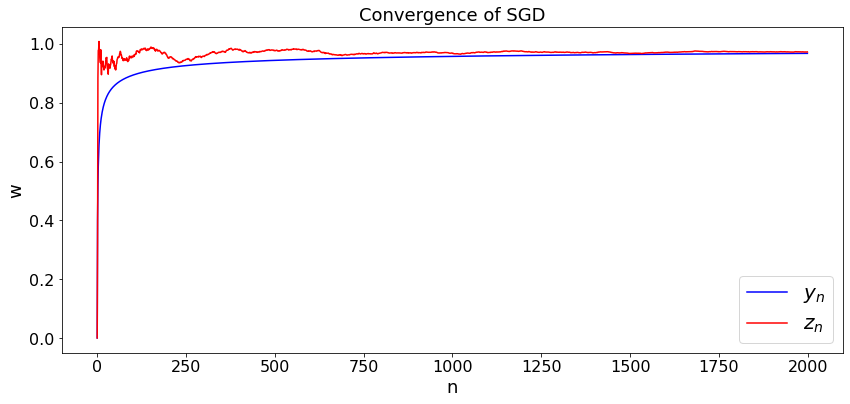

In [10]:
def MG2(case,N):  # LR 
    t = np.arange(0,N)
    y = np.arange(0.0,N)
    y[0] = 0
    z = np.arange(0.0,N)
    z[0] = 0
    
    for k in range(N-1):
        if case == '(a)':
            x =  np.random.normal()
        else:
            x =  - 1+ 2*np.random.random()
        y[k+1] = y[k] + 0.4*(1 - y[k])/(k+1)
        z[k+1] = z[k] + 0.4*(1 - z[k]+ x)/(k+1)
    plt.figure(figsize = (14,6))
    plt.plot(t, y, c='b',label='$y_n$')
    plt.legend()
    plt.plot(t, z, c='r',label='$z_n$')
    plt.legend()
    plt.title('Convergence of SGD')
    plt.xlabel('n')
    plt.ylabel('w')
    plt.show()
            
MG2(case,N)
        